# Image Model Training

This notebook trains two image classification models on the CUB-200-2011 dataset:
1. **ResNet-18** - CNN-based architecture with residual connections
2. **ViT-B/16** - Vision Transformer with self-attention

Both models are trained on 90 species from the intersection of Xeno-Canto and CUB datasets.

In [4]:
import sys
from pathlib import Path
import pandas as pd
import json
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, str(Path('..').resolve()))

from src.models.image_resnet import ImageResNet
from src.models.image_vit import ImageViT
from src.datasets.image import ImageDataset, get_image_transforms
from src.training.trainer import Trainer

ARTIFACTS = Path('../artifacts')
MODELS_DIR = ARTIFACTS / 'models'
MODELS_DIR.mkdir(exist_ok=True)

device_obj = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = str(device_obj)
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.9.1+cu128
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


## Load Data and Create Splits

In [5]:
# Load filtered CUB data
cub_df = pd.read_parquet(ARTIFACTS / 'cub_filtered.parquet')

# Filter to species with >=2 samples (needed for stratification)
cub_counts = cub_df['species_normalized'].value_counts()
species_to_keep = cub_counts[cub_counts >= 2].index
cub_df = cub_df[cub_df['species_normalized'].isin(species_to_keep)].copy()

# Load splits
with open(ARTIFACTS / 'splits' / 'cub_image_splits.json', 'r') as f:
    splits = json.load(f)

# Create species to label mapping
species_list = sorted(cub_df['species_normalized'].unique())
species_to_idx = {sp: i for i, sp in enumerate(species_list)}
num_classes = len(species_list)

print(f"Dataset: {len(cub_df)} images, {num_classes} species")
print(f"Train: {len(splits['train'])} samples")
print(f"Val: {len(splits['val'])} samples")
print(f"Test: {len(splits['test'])} samples")

# Show species distribution
print(f"\nSample species:")
for sp in species_list[:5]:
    count = (cub_df['species_normalized'] == sp).sum()
    print(f"  {sp}: {count} images")

Dataset: 5385 images, 90 species
Train: 3769 samples
Val: 808 samples
Test: 808 samples

Sample species:
  american crow: 60 images
  american goldfinch: 60 images
  american redstart: 60 images
  baltimore oriole: 60 images
  barn swallow: 60 images


## Create Datasets and DataLoaders

In [6]:
# Create datasets with transforms
train_dataset = ImageDataset(
    df=cub_df,
    indices=splits['train'],
    species_to_idx=species_to_idx,
    transform=get_image_transforms(train=True, image_size=224)
)

val_dataset = ImageDataset(
    df=cub_df,
    indices=splits['val'],
    species_to_idx=species_to_idx,
    transform=get_image_transforms(train=False, image_size=224)
)

test_dataset = ImageDataset(
    df=cub_df,
    indices=splits['test'],
    species_to_idx=species_to_idx,
    transform=get_image_transforms(train=False, image_size=224)
)

print(f"Dataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, 
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f"\nDataloader batches:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")

Dataset sizes:
  Train: 3769
  Val: 808
  Test: 808

Dataloader batches:
  Train: 118 batches
  Val: 26 batches
  Test: 26 batches


## Train ResNet-18

ResNet-18 is a convolutional neural network with 18 layers and skip connections. We use transfer learning with ImageNet pre-trained weights.

In [7]:
# Initialize ResNet-18
model = ImageResNet(num_classes=num_classes, pretrained=True).to(device_obj)
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

# Setup optimizer and scheduler
optimizer = torch.optim.SGD(
    model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    checkpoint_dir=MODELS_DIR / 'image_resnet18',
    experiment_name='ImageResNet18',
    use_amp=True,
    gradient_clip=1.0,
    early_stopping_patience=10
)

print("\n🚀 Starting ResNet-18 training...")
print("This may take 30-60 minutes depending on your GPU.\n")

/home/giovanni/ufmg/speckitdlbird/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/giovanni/ufmg/speckitdlbird/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model: 11,222,682 parameters

🚀 Starting ResNet-18 training...
This may take 30-60 minutes depending on your GPU.



/home/giovanni/ufmg/speckitdlbird/src/training/trainer.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler() if self.use_amp else None


In [9]:
# Train the model
history = trainer.train(num_epochs=50)

print(f"\n✓ ResNet-18 training complete")
print(f"✓ Best val accuracy: {max(history['val_acc']):.4f}")
print(f"✓ Final train loss: {history['train_loss'][-1]:.4f}")
print(f"✓ Final val loss: {history['val_loss'][-1]:.4f}")

Training ImageResNet18 for 50 epochs...
Device: cuda, AMP: True

Epoch 1/50


Training:   0%|          | 0/118 [00:00<?, ?it/s]/home/giovanni/ufmg/speckitdlbird/src/training/trainer.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/26 [00:00<?, ?it/s]/home/giovanni/ufmg/speckitdlbird/src/training/trainer.py:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 26/26 [00:01<00:00, 16.16it/s]


Train Loss: 4.1635, Train Acc: 9.95%
Val Loss: 3.1443, Val Acc: 36.51%
✓ Saved checkpoint (Val Acc: 36.51%)

Epoch 2/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.81it/s]


Train Loss: 2.8896, Train Acc: 39.90%
Val Loss: 1.9151, Val Acc: 58.29%
✓ Saved checkpoint (Val Acc: 58.29%)

Epoch 3/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.46it/s]


Train Loss: 2.1420, Train Acc: 54.58%
Val Loss: 1.3746, Val Acc: 69.31%
✓ Saved checkpoint (Val Acc: 69.31%)

Epoch 4/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.83it/s]


Train Loss: 1.7145, Train Acc: 62.62%
Val Loss: 1.0989, Val Acc: 75.99%
✓ Saved checkpoint (Val Acc: 75.99%)

Epoch 5/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.98it/s]


Train Loss: 1.4719, Train Acc: 67.55%
Val Loss: 0.9185, Val Acc: 78.84%
✓ Saved checkpoint (Val Acc: 78.84%)

Epoch 6/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.18it/s]


Train Loss: 1.2811, Train Acc: 71.93%
Val Loss: 0.8032, Val Acc: 79.21%
✓ Saved checkpoint (Val Acc: 79.21%)

Epoch 7/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.84it/s]


Train Loss: 1.1598, Train Acc: 73.95%
Val Loss: 0.7439, Val Acc: 81.06%
✓ Saved checkpoint (Val Acc: 81.06%)

Epoch 8/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.85it/s]


Train Loss: 1.0548, Train Acc: 76.57%
Val Loss: 0.6907, Val Acc: 82.05%
✓ Saved checkpoint (Val Acc: 82.05%)

Epoch 9/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.48it/s]


Train Loss: 0.9686, Train Acc: 78.69%
Val Loss: 0.6551, Val Acc: 82.80%
✓ Saved checkpoint (Val Acc: 82.80%)

Epoch 10/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.32it/s]


Train Loss: 0.9231, Train Acc: 78.77%
Val Loss: 0.6073, Val Acc: 83.29%
✓ Saved checkpoint (Val Acc: 83.29%)

Epoch 11/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.54it/s]


Train Loss: 0.8673, Train Acc: 81.35%
Val Loss: 0.5744, Val Acc: 85.02%
✓ Saved checkpoint (Val Acc: 85.02%)

Epoch 12/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.05it/s]


Train Loss: 0.8163, Train Acc: 82.49%
Val Loss: 0.5735, Val Acc: 84.78%

Epoch 13/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.61it/s]


Train Loss: 0.8475, Train Acc: 81.24%
Val Loss: 0.5657, Val Acc: 85.40%
✓ Saved checkpoint (Val Acc: 85.40%)

Epoch 14/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 14.98it/s]


Train Loss: 0.8138, Train Acc: 82.70%
Val Loss: 0.5581, Val Acc: 84.78%

Epoch 15/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.38it/s]


Train Loss: 0.7957, Train Acc: 82.78%
Val Loss: 0.5615, Val Acc: 84.78%

Epoch 16/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.28it/s]


Train Loss: 0.8127, Train Acc: 82.54%
Val Loss: 0.5566, Val Acc: 85.40%

Epoch 17/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.71it/s]


Train Loss: 0.7598, Train Acc: 83.02%
Val Loss: 0.5527, Val Acc: 85.15%

Epoch 18/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.63it/s]


Train Loss: 0.7809, Train Acc: 83.07%
Val Loss: 0.5494, Val Acc: 85.64%
✓ Saved checkpoint (Val Acc: 85.64%)

Epoch 19/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.45it/s]


Train Loss: 0.7615, Train Acc: 83.39%
Val Loss: 0.5530, Val Acc: 85.89%
✓ Saved checkpoint (Val Acc: 85.89%)

Epoch 20/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.90it/s]


Train Loss: 0.7917, Train Acc: 82.04%
Val Loss: 0.5448, Val Acc: 85.77%

Epoch 21/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.85it/s]


Train Loss: 0.7776, Train Acc: 83.36%
Val Loss: 0.5419, Val Acc: 86.26%
✓ Saved checkpoint (Val Acc: 86.26%)

Epoch 22/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.31it/s]


Train Loss: 0.7239, Train Acc: 84.24%
Val Loss: 0.5425, Val Acc: 85.77%

Epoch 23/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.59it/s]


Train Loss: 0.7636, Train Acc: 83.60%
Val Loss: 0.5440, Val Acc: 85.89%

Epoch 24/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.33it/s]


Train Loss: 0.7438, Train Acc: 84.40%
Val Loss: 0.5489, Val Acc: 85.64%

Epoch 25/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.19it/s]


Train Loss: 0.7320, Train Acc: 83.79%
Val Loss: 0.5407, Val Acc: 86.39%
✓ Saved checkpoint (Val Acc: 86.39%)

Epoch 26/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.61it/s]


Train Loss: 0.7349, Train Acc: 83.74%
Val Loss: 0.5448, Val Acc: 85.64%

Epoch 27/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 15.87it/s]


Train Loss: 0.7781, Train Acc: 82.52%
Val Loss: 0.5451, Val Acc: 85.64%

Epoch 28/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.11it/s]


Train Loss: 0.7375, Train Acc: 84.56%
Val Loss: 0.5491, Val Acc: 85.77%

Epoch 29/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.72it/s]


Train Loss: 0.7847, Train Acc: 82.99%
Val Loss: 0.5427, Val Acc: 85.77%

Epoch 30/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.89it/s]


Train Loss: 0.7504, Train Acc: 84.00%
Val Loss: 0.5459, Val Acc: 85.77%

Epoch 31/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.32it/s]


Train Loss: 0.7253, Train Acc: 84.48%
Val Loss: 0.5414, Val Acc: 85.64%

Epoch 32/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 16.82it/s]


Train Loss: 0.7754, Train Acc: 83.55%
Val Loss: 0.5450, Val Acc: 85.77%

Epoch 33/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.19it/s]


Train Loss: 0.7569, Train Acc: 83.55%
Val Loss: 0.5443, Val Acc: 86.26%

Epoch 34/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.05it/s]


Train Loss: 0.7699, Train Acc: 83.47%
Val Loss: 0.5423, Val Acc: 85.64%

Epoch 35/50


Validation: 100%|██████████| 26/26 [00:01<00:00, 17.28it/s]

Train Loss: 0.7609, Train Acc: 82.83%
Val Loss: 0.5454, Val Acc: 86.14%

Early stopping after 35 epochs (no improvement for 10 epochs)

Training complete! Best Val Acc: 86.39%

✓ ResNet-18 training complete
✓ Best val accuracy: 86.3861
✓ Final train loss: 0.7609
✓ Final val loss: 0.5454


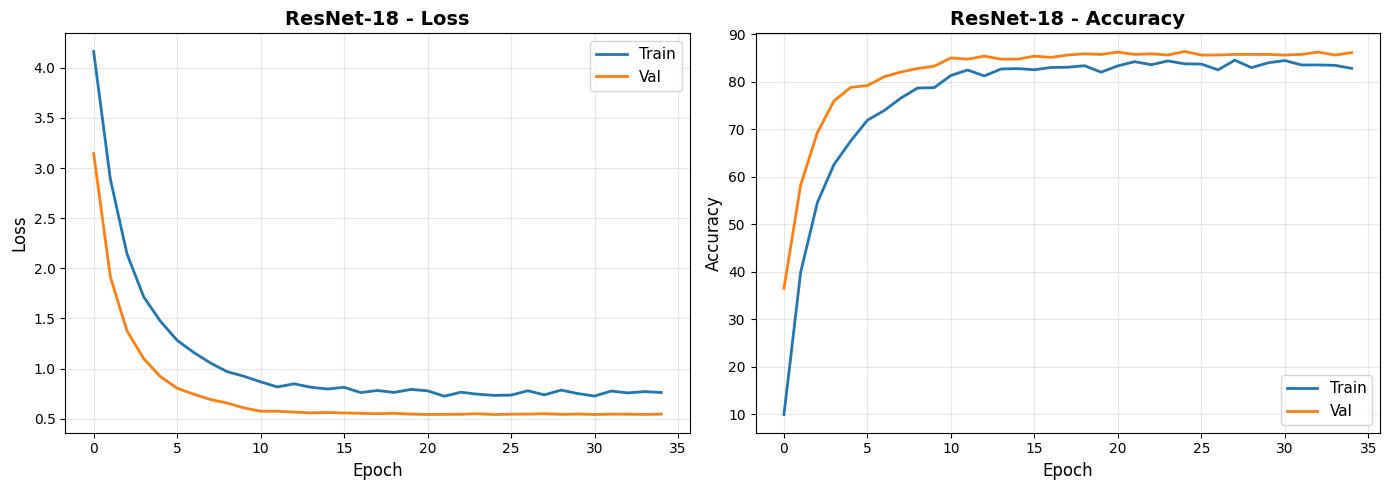

✓ Saved training curves and history to ../artifacts/models/image_resnet18


In [10]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('ResNet-18 - Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train', linewidth=2)
axes[1].plot(history['val_acc'], label='Val', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('ResNet-18 - Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'image_resnet18' / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Save history
with open(MODELS_DIR / 'image_resnet18' / 'history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f, indent=2)
    
print(f"✓ Saved training curves and history to {MODELS_DIR / 'image_resnet18'}")

## Train Vision Transformer (ViT-B/16)

Vision Transformer applies self-attention mechanisms to image patches. We use the base model with 16x16 patches.

In [11]:
# Initialize ViT-B/16
model = ImageViT(num_classes=num_classes, pretrained='google/vit-base-patch16-224').to(device_obj)
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

# Setup optimizer and scheduler (AdamW + Cosine annealing for ViT)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=50, eta_min=1e-6
)

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    checkpoint_dir=MODELS_DIR / 'image_vit',
    experiment_name='ImageViT',
    use_amp=True,
    gradient_clip=1.0,
    early_stopping_patience=10
)

print("\n🚀 Starting ViT-B/16 training...")
print("This may take 45-90 minutes depending on your GPU.\n")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: 85,867,866 parameters

🚀 Starting ViT-B/16 training...
This may take 45-90 minutes depending on your GPU.



In [12]:
# Train the model
vit_history = trainer.train(num_epochs=50)

print(f"\n✓ ViT-B/16 training complete")
print(f"✓ Best val accuracy: {max(vit_history['val_acc']):.4f}")
print(f"✓ Final train loss: {vit_history['train_loss'][-1]:.4f}")
print(f"✓ Final val loss: {vit_history['val_loss'][-1]:.4f}")

Training ImageViT for 50 epochs...
Device: cuda, AMP: True

Epoch 1/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.18it/s]


Train Loss: 2.4728, Train Acc: 54.71%
Val Loss: 0.6765, Val Acc: 87.50%
✓ Saved checkpoint (Val Acc: 87.50%)

Epoch 2/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.12it/s]


Train Loss: 0.7531, Train Acc: 83.42%
Val Loss: 0.3682, Val Acc: 89.48%
✓ Saved checkpoint (Val Acc: 89.48%)

Epoch 3/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.15it/s]


Train Loss: 0.5467, Train Acc: 86.73%
Val Loss: 0.3503, Val Acc: 90.47%
✓ Saved checkpoint (Val Acc: 90.47%)

Epoch 4/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.99it/s]


Train Loss: 0.4505, Train Acc: 89.04%
Val Loss: 0.3054, Val Acc: 91.21%
✓ Saved checkpoint (Val Acc: 91.21%)

Epoch 5/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.05it/s]


Train Loss: 0.4238, Train Acc: 89.97%
Val Loss: 0.3035, Val Acc: 91.34%
✓ Saved checkpoint (Val Acc: 91.34%)

Epoch 6/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.91it/s]


Train Loss: 0.3863, Train Acc: 90.45%
Val Loss: 0.3003, Val Acc: 91.71%
✓ Saved checkpoint (Val Acc: 91.71%)

Epoch 7/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.98it/s]


Train Loss: 0.3653, Train Acc: 91.09%
Val Loss: 0.3038, Val Acc: 91.83%
✓ Saved checkpoint (Val Acc: 91.83%)

Epoch 8/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.83it/s]


Train Loss: 0.3554, Train Acc: 90.79%
Val Loss: 0.3076, Val Acc: 90.84%

Epoch 9/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.75it/s]


Train Loss: 0.3151, Train Acc: 92.01%
Val Loss: 0.3168, Val Acc: 91.46%

Epoch 10/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.12it/s]


Train Loss: 0.3104, Train Acc: 92.09%
Val Loss: 0.3587, Val Acc: 89.85%

Epoch 11/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.96it/s]


Train Loss: 0.3040, Train Acc: 92.39%
Val Loss: 0.3326, Val Acc: 90.59%

Epoch 12/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.96it/s]


Train Loss: 0.2906, Train Acc: 92.57%
Val Loss: 0.3644, Val Acc: 90.10%

Epoch 13/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.00it/s]


Train Loss: 0.2740, Train Acc: 93.02%
Val Loss: 0.3152, Val Acc: 91.34%

Epoch 14/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.00it/s]


Train Loss: 0.2692, Train Acc: 93.13%
Val Loss: 0.3456, Val Acc: 91.21%

Epoch 15/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.95it/s]


Train Loss: 0.2762, Train Acc: 93.08%
Val Loss: 0.3131, Val Acc: 92.20%
✓ Saved checkpoint (Val Acc: 92.20%)

Epoch 16/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.90it/s]


Train Loss: 0.2336, Train Acc: 93.98%
Val Loss: 0.3479, Val Acc: 90.97%

Epoch 17/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.78it/s]


Train Loss: 0.2284, Train Acc: 94.03%
Val Loss: 0.3487, Val Acc: 91.71%

Epoch 18/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.66it/s]


Train Loss: 0.2297, Train Acc: 94.61%
Val Loss: 0.3611, Val Acc: 91.71%

Epoch 19/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.94it/s]


Train Loss: 0.2121, Train Acc: 94.91%
Val Loss: 0.3685, Val Acc: 90.84%

Epoch 20/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.82it/s]


Train Loss: 0.2349, Train Acc: 94.35%
Val Loss: 0.3848, Val Acc: 90.84%

Epoch 21/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.78it/s]


Train Loss: 0.2141, Train Acc: 94.77%
Val Loss: 0.3660, Val Acc: 91.21%

Epoch 22/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.83it/s]


Train Loss: 0.2080, Train Acc: 94.77%
Val Loss: 0.3549, Val Acc: 91.58%

Epoch 23/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.00it/s]


Train Loss: 0.1944, Train Acc: 95.17%
Val Loss: 0.3769, Val Acc: 90.59%

Epoch 24/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.84it/s]


Train Loss: 0.2073, Train Acc: 95.01%
Val Loss: 0.3380, Val Acc: 92.57%
✓ Saved checkpoint (Val Acc: 92.57%)

Epoch 25/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.90it/s]


Train Loss: 0.1830, Train Acc: 95.28%
Val Loss: 0.3601, Val Acc: 92.33%

Epoch 26/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.01it/s]


Train Loss: 0.1646, Train Acc: 95.62%
Val Loss: 0.3919, Val Acc: 91.58%

Epoch 27/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.86it/s]


Train Loss: 0.1623, Train Acc: 95.68%
Val Loss: 0.3322, Val Acc: 92.33%

Epoch 28/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.89it/s]


Train Loss: 0.1735, Train Acc: 95.62%
Val Loss: 0.3629, Val Acc: 90.72%

Epoch 29/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.07it/s]


Train Loss: 0.1823, Train Acc: 95.38%
Val Loss: 0.3396, Val Acc: 91.83%

Epoch 30/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.97it/s]


Train Loss: 0.1531, Train Acc: 96.13%
Val Loss: 0.3374, Val Acc: 92.08%

Epoch 31/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 11.03it/s]


Train Loss: 0.1650, Train Acc: 95.83%
Val Loss: 0.3260, Val Acc: 92.08%

Epoch 32/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.89it/s]


Train Loss: 0.1448, Train Acc: 96.15%
Val Loss: 0.3553, Val Acc: 92.20%

Epoch 33/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.95it/s]


Train Loss: 0.1460, Train Acc: 96.47%
Val Loss: 0.3440, Val Acc: 92.20%

Epoch 34/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.99it/s]


Train Loss: 0.1295, Train Acc: 96.58%
Val Loss: 0.3443, Val Acc: 92.95%
✓ Saved checkpoint (Val Acc: 92.95%)

Epoch 35/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.76it/s]


Train Loss: 0.1310, Train Acc: 96.52%
Val Loss: 0.3382, Val Acc: 92.82%

Epoch 36/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.90it/s]


Train Loss: 0.1304, Train Acc: 96.95%
Val Loss: 0.3426, Val Acc: 92.70%

Epoch 37/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.92it/s]


Train Loss: 0.1350, Train Acc: 96.74%
Val Loss: 0.3325, Val Acc: 93.44%
✓ Saved checkpoint (Val Acc: 93.44%)

Epoch 38/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.87it/s]


Train Loss: 0.1500, Train Acc: 96.26%
Val Loss: 0.3363, Val Acc: 92.57%

Epoch 39/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.82it/s]


Train Loss: 0.1364, Train Acc: 96.52%
Val Loss: 0.3320, Val Acc: 92.33%

Epoch 40/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.94it/s]


Train Loss: 0.1236, Train Acc: 96.76%
Val Loss: 0.3336, Val Acc: 92.70%

Epoch 41/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.67it/s]


Train Loss: 0.1263, Train Acc: 96.82%
Val Loss: 0.3364, Val Acc: 92.20%

Epoch 42/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.83it/s]


Train Loss: 0.1050, Train Acc: 97.51%
Val Loss: 0.3417, Val Acc: 92.20%

Epoch 43/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.90it/s]


Train Loss: 0.1031, Train Acc: 97.27%
Val Loss: 0.3453, Val Acc: 92.20%

Epoch 44/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.85it/s]


Train Loss: 0.1186, Train Acc: 97.19%
Val Loss: 0.3414, Val Acc: 92.57%

Epoch 45/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.99it/s]


Train Loss: 0.1244, Train Acc: 96.87%
Val Loss: 0.3441, Val Acc: 92.33%

Epoch 46/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.99it/s]


Train Loss: 0.0995, Train Acc: 97.32%
Val Loss: 0.3438, Val Acc: 92.45%

Epoch 47/50


Validation: 100%|██████████| 26/26 [00:02<00:00, 10.98it/s]

Train Loss: 0.1203, Train Acc: 96.95%
Val Loss: 0.3435, Val Acc: 92.33%

Early stopping after 47 epochs (no improvement for 10 epochs)

Training complete! Best Val Acc: 93.44%

✓ ViT-B/16 training complete
✓ Best val accuracy: 93.4406
✓ Final train loss: 0.1203
✓ Final val loss: 0.3435


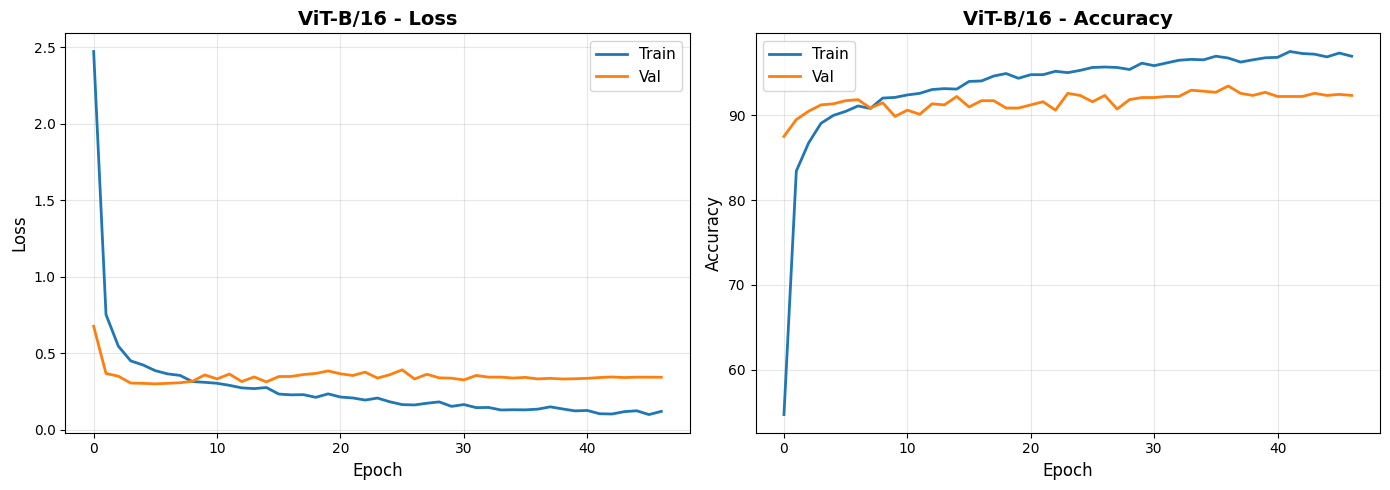

✓ Saved training curves and history to ../artifacts/models/image_vit


In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(vit_history['train_loss'], label='Train', linewidth=2)
axes[0].plot(vit_history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('ViT-B/16 - Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(vit_history['train_acc'], label='Train', linewidth=2)
axes[1].plot(vit_history['val_acc'], label='Val', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('ViT-B/16 - Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(MODELS_DIR / 'image_vit' / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Save history
with open(MODELS_DIR / 'image_vit' / 'history.json', 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in vit_history.items()}, f, indent=2)
    
print(f"✓ Saved training curves and history to {MODELS_DIR / 'image_vit'}")

## Summary

Both image models have been trained and their checkpoints saved. The models can now be evaluated on the test set.